In [1]:
import warnings
warnings.filterwarnings('ignore')


def read_json_file(file_path):
    """
    Reads a JSON file with multiple JSON objects (one per line) and returns the data as a list of dictionaries.
    
    Args:||
        file_path (str): The path to the JSON file.
    
    Returns:
        list: A list of dictionaries containing the data from the JSON file.
    """
    data = []
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            for line in file:
                try:
                    json_obj = json.loads(line)
                    data.append(json_obj)
                except json.JSONDecodeError as e:
                    print(f"JSONDecodeError in line: {line.strip()}")
                    print(f"Error message: {e}")
        return data
    except FileNotFoundError:
        print(f"The file at {file_path} does not exist.")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None


In [2]:
def extract_data_without_tag(prompt):
    prompts = prompt['prompt']

    last_utter = f"{prompt['last_speaker']} :" 

    dialogue = prompts + last_utter
    
    return dialogue, prompt['last_speaker'], prompt['answer']
    

def extract_data_with_tag(prompt):
    prompts = prompt['prompt']

    last_utter = f"{prompt['last_speaker']} : ({prompt['gold_tag']})" 

    dialogue = prompts + last_utter
    
    return dialogue, prompt['last_speaker'], prompt['gold_tag'], prompt['answer']

def distinct_ngrams(sentences, n):
    """
    Calculate the distinct-n metric for a list of sentences.
    
    Args:
        sentences (list of str): The list of sentences generated by the model.
        n (int): The n-gram length.

    Returns:
        float: The distinct-n score.
    """
    ngrams = Counter()
    total_ngrams = 0

    for sentence in sentences:
        tokens = sentence.split()
        sentence_ngrams = zip(*[tokens[i:] for i in range(n)])
        ngrams.update(sentence_ngrams)
        total_ngrams += len(tokens) - n + 1
    
    return len(ngrams) / total_ngrams if total_ngrams > 0 else 0


def get_ppl(text, model, tokenizer,device):

    # Encode the input sentence
    inputs = tokenizer(text, return_tensors='pt').to(device)
    input_ids = inputs['input_ids']
    
    # Get the output logits
    with torch.no_grad():
        outputs = model(input_ids, labels=input_ids)
    
    # Calculate the loss (cross entropy)
    loss = outputs.loss.item()
    
    # Convert the loss to perplexity
    perplexity = math.exp(loss)
    
    return perplexity

In [3]:
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import re
import torch
import evaluate
from evaluate import load
current_dir = os.getcwd()
episode_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(episode_dir)

from utils.model_utils import get_peft_checkpoint, generate, get_peft_checkpoint_
from tqdm import tqdm


from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer)

import torch
import math

import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def evaluation_chat_system(num, prompt , model, tokenizer, device, bert_eval,rough_eval):
    
    if num == 2:
        print("This is a wo tag evaluation")
        print(prompt)
        input__, person, utterance,  = extract_data_without_tag(prompt)
        print(f'Last word -> {person} : "{utterance}"')
        
        input_ = tokenizer(input__, return_tensors = 'pt').to(device)     
        output = generate(model,tokenizer,
                                      input_,
                                      num_beams=1,
                                      num_return_sequences=1,
                                      max_new_tokens=100)


        
        response = output.replace(input__, '')
        response = response.split("\n")[0]
        print(f"prediction : {response}")
        print(f"Real answer : {utterance}")

        reference = [utterance.split()]
        candidate = response.split()

            
        output_list = [response.strip()]
        last_utter_list = [utterance.strip()]
        #evalation
        bert_score = bert_eval.compute(predictions=output_list, references=last_utter_list, lang="en")
        rouge_score = rouge_eval.compute(predictions=output_list, references=last_utter_list)

        ## bleu

        weights_unigram = (1, 0, 0, 0)
        bleu_unigram = sentence_bleu(reference, candidate, weights=weights_unigram, smoothing_function=SmoothingFunction().method1)

        weights_bigram = (0.5, 0.5, 0, 0)
        bleu_bigram = sentence_bleu(reference, candidate, weights=weights_bigram, smoothing_function=SmoothingFunction().method1)

        ### ppl
        ppl = get_ppl(response, model, tokenizer,device)
        
        print(f"Bert Score : {bert_score}")
        print(f"Rouge Score : {rouge_score}")
        print(f"bleu 1/2 : {bleu_unigram} {bleu_bigram}")
        print(f"ppl : {ppl}")
        return bert_score, rouge_score, bleu_unigram, bleu_bigram, response ,ppl
    
    
    if num == 3:
        print("This is with tag evaluation")
        print(prompt)
        input__ , person, trait, utterance = extract_data_with_tag(prompt)
        print(f'Last word -> {person} : ({trait}) "{utterance}"')
        
        input_ = tokenizer(input__, return_tensors = 'pt').to(device)
     
        output = generate(model,tokenizer,
                                      input_,
                                      num_beams=1,
                                      num_return_sequences=1,
                                      max_new_tokens=100)


        ### utterance : correct answer
        ### response : Model-generated answer

        response = output.replace(input__, '').split("\n")[0]
        
        print(f"prediction : {response}")
        print(f"Real answer : {utterance}")
        
        output_list = [response.strip()]
        last_utter_list = [utterance.strip()]

        reference = [utterance.split()]
        candidate = response.split()

        #evalation
        bert_score = bert_eval.compute(predictions=output_list, references=last_utter_list, lang="en")
        rouge_score = rouge_eval.compute(predictions=output_list, references=last_utter_list)

        ## bleu

        weights_unigram = (1, 0, 0, 0)
        bleu_unigram = sentence_bleu(reference, candidate, weights=weights_unigram, smoothing_function=SmoothingFunction().method1)

        weights_bigram = (0.5, 0.5, 0, 0)
        bleu_bigram = sentence_bleu(reference, candidate, weights=weights_bigram, smoothing_function=SmoothingFunction().method1)

        ### ppl
        ppl = get_ppl(response, model, tokenizer,device)
        
        print(f"Bert Score : {bert_score}")
        print(f"Rouge Score : {rouge_score}")
        print(f"bleu 1/2 : {bleu_unigram} {bleu_bigram}")
        print(f"ppl : {ppl}")

        
        return bert_score, rouge_score, bleu_unigram, bleu_bigram, response ,ppl

In [4]:
path = 'chano12/llama_without_tag'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model, tokenizer = get_peft_checkpoint(path, device)

adapter_config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/16.8M [00:00<?, ?B/s]

In [5]:
import json

path = '/home/chanho/Model/SHARE/Refactorizing/result/dataset/test_without_tag.json'

json_data = read_json_file(path)

In [6]:
bert = []
rough = []
bleu_1_list = []
bleu_2_list = []
infer = []
ppl_list = []

In [7]:
bertscore_eval = load("bertscore")
rouge_eval = evaluate.load('rouge') 

for prompt in json_data:
    bert_score, rough_score, bleu_1, bleu_2, infer_sentence, ppl = evaluation_chat_system(2, prompt ,model, tokenizer,device, bertscore_eval, rouge_eval)
    bert.append(bert_score)
    rough.append(rough_score)
    bleu_1_list.append(bleu_1)
    bleu_2_list.append(bleu_2)
    infer.append(infer_sentence)
    ppl_list.append(ppl)

This is a wo tag evaluation
{'prompt': "\nTask: Generate the next response in the dialogue based on the provided history. The response should logically follow and predict the next reply considering the context of the conversation.\n\n**Dialogue History**:\nLOLA: Hello, Mr. Neff. It's me.\nNEFF: Something the matter?\nLOLA: I've been waiting for you.\nNEFF: For me? What for?\nLOLA: I thought you could let me ride with you, if you're going my way.\n\n", 'answer': "Which way would that be? Oh, sure. Vermont and Franklin. North- west corner, wasn't it? Be glad to, Miss Dietrichson.", 'gold_tag': 'NEFF is familiar with the local geographic area , NEFF references specific streets', 'last_speaker': 'NEFF'}
Last word -> NEFF : "Which way would that be? Oh, sure. Vermont and Franklin. North- west corner, wasn't it? Be glad to, Miss Dietrichson."
prediction :  I don't know. I'm on my way to see Mr. Gittes.
Real answer : Which way would that be? Oh, sure. Vermont and Franklin. North- west corner,

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Bert Score : {'precision': [0.855631947517395], 'recall': [0.818554699420929], 'f1': [0.8366827368736267], 'hashcode': 'roberta-large_L17_no-idf_version=0.3.12(hug_trans=4.41.0.dev0)'}
Rouge Score : {'rouge1': 0.17647058823529413, 'rouge2': 0.0, 'rougeL': 0.11764705882352941, 'rougeLsum': 0.11764705882352941}
bleu 1/2 : 0.040112106159998544 0.013303680568361875
ppl : 17.192608633564788
This is a wo tag evaluation
{'prompt': "\nTask: Generate the next response in the dialogue based on the provided history. The response should logically follow and predict the next reply considering the context of the conversation.\n\n**Dialogue History**:\nNEFF: Roller skating, eh? You like roller skating?\nLOLA: I can take it or leave it.\nNEFF: Only tonight you're leaving it?\nLOLA: Yes, I am. You see, Mr. Neff, I'm having a very tough time at home. My father doesn't understand me and Phyllis hates me.\nNEFF: That does sound tough, all right.\nLOLA: That's why I have to lie sometimes.\nNEFF: You mean i

prediction :  What's that?
Real answer : Let's go!
Bert Score : {'precision': [0.839039146900177], 'recall': [0.829700231552124], 'f1': [0.8343435525894165], 'hashcode': 'roberta-large_L17_no-idf_version=0.3.12(hug_trans=4.41.0.dev0)'}
Rouge Score : {'rouge1': 0.3333333333333333, 'rouge2': 0.0, 'rougeL': 0.3333333333333333, 'rougeLsum': 0.3333333333333333}
bleu 1/2 : 0 0
ppl : 87.94740186916538
This is a wo tag evaluation
{'prompt': "\nTask: Generate the next response in the dialogue based on the provided history. The response should logically follow and predict the next reply considering the context of the conversation.\n\n**Dialogue History**:\nMIKE: How did the visit go?\nKYLE: OK. He fell asleep watching TV. So he lives there now?\nMIKE: Yeah. Your grandfather is in the things that don't make sense.\nKYLE: Are you a friend of his or something?\nMIKE: I'm his guardian.\nKYLE: What's that mean?\nMIKE: It means I make sure he's well taken care of.\n\n", 'answer': "That's cool.", 'gold

Bert Score : {'precision': [0.0], 'recall': [0.0], 'f1': [0.0], 'hashcode': 'roberta-large_L17_no-idf_version=0.3.12(hug_trans=4.41.0.dev0)'}
Rouge Score : {'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0, 'rougeLsum': 0.0}
bleu 1/2 : 0 0
ppl : 5830.757790976462
This is a wo tag evaluation
{'prompt': '\nTask: Generate the next response in the dialogue based on the provided history. The response should logically follow and predict the next reply considering the context of the conversation.\n\n**Dialogue History**:\nADAM: Hey, what are you doing?!\n\n', 'answer': 'I know a short-cut.', 'gold_tag': 'Everyday Language', 'last_speaker': 'EVE'}
Last word -> EVE : "I know a short-cut."
prediction :  I'm making a necklace.
Real answer : I know a short-cut.
Bert Score : {'precision': [0.8951449394226074], 'recall': [0.8898839950561523], 'f1': [0.8925066590309143], 'hashcode': 'roberta-large_L17_no-idf_version=0.3.12(hug_trans=4.41.0.dev0)'}
Rouge Score : {'rouge1': 0.4000000000000001, 'rouge2': 0.0

prediction :  A baby crying.
Real answer : The sound of money.
Bert Score : {'precision': [0.9068498611450195], 'recall': [0.8848618268966675], 'f1': [0.895720899105072], 'hashcode': 'roberta-large_L17_no-idf_version=0.3.12(hug_trans=4.41.0.dev0)'}
Rouge Score : {'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0, 'rougeLsum': 0.0}
bleu 1/2 : 0 0
ppl : 397.27649215448474
This is a wo tag evaluation
{'prompt': '\nTask: Generate the next response in the dialogue based on the provided history. The response should logically follow and predict the next reply considering the context of the conversation.\n\n**Dialogue History**:\nVIOLET (V.O.): Waiting for what?\n\n', 'answer': "For the shower. That will be our signal. When he's done with his shower, you will go to the bar.", 'gold_tag': 'CORKY V.O. is waiting for someone to finish their shower , VIOLET V.O. is to go to the bar after the shower is done', 'last_speaker': 'CORKY (V.O.)'}
Last word -> CORKY (V.O.) : "For the shower. That will be our si

prediction :  Moscow?
Real answer : Give Ripcord the coordinates.
Bert Score : {'precision': [0.846744179725647], 'recall': [0.8307751417160034], 'f1': [0.8386836647987366], 'hashcode': 'roberta-large_L17_no-idf_version=0.3.12(hug_trans=4.41.0.dev0)'}
Rouge Score : {'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0, 'rougeLsum': 0.0}
bleu 1/2 : 0 0
ppl : 5768.892528634968
This is a wo tag evaluation
{'prompt': '\nTask: Generate the next response in the dialogue based on the provided history. The response should logically follow and predict the next reply considering the context of the conversation.\n\n**Dialogue History**:\nBREAKER: Energy overload in the phased array\n\n', 'answer': "Let's get out of here!", 'gold_tag': 'SCARLETT is assertive and safety-conscious , SCARLETT made an immediate decision to abandon the compromised site', 'last_speaker': 'SCARLETT'}
Last word -> SCARLETT : "Let's get out of here!"
prediction :  What's the problem?
Real answer : Let's get out of here!
Bert Score 

prediction :  Don't worry. You were great.
Real answer : I can go for longer than that.
Bert Score : {'precision': [0.882824182510376], 'recall': [0.8592315912246704], 'f1': [0.8708680868148804], 'hashcode': 'roberta-large_L17_no-idf_version=0.3.12(hug_trans=4.41.0.dev0)'}
Rouge Score : {'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0, 'rougeLsum': 0.0}
bleu 1/2 : 0 0
ppl : 50.62933854402548
This is a wo tag evaluation
{'prompt': '\nTask: Generate the next response in the dialogue based on the provided history. The response should logically follow and predict the next reply considering the context of the conversation.\n\n**Dialogue History**:\nDIANA: Lady Jane Neville.\nROBIN: Good for?\nDIANA: A thousand at least, if she’s in the mood.\nROBIN: Am I plucky or pitiful?\n\n', 'answer': 'I think plucky. These old dowagers are tough as nails.', 'gold_tag': 'DIANA is aware of the nature of "old dowagers" , ROBIN implies potential hardship but a resilient attitude', 'last_speaker': 'DIANA'}
Last

In [ ]:
ber = [i['precision'][0] for i in bert]

In [11]:
def calculate_mean(tensor_list):
    # Move tensors to CPU and convert to numpy arrays
    valid_tensors = [t for t in tensor_list if not torch.isnan(t)]
    cpu_tensors = [t.cpu().numpy() for t in valid_tensors]
    cpu_tensors = [float(i) for i in cpu_tensors]

    return cpu_tensors

In [20]:
np.mean(sorted(calculate_mean(ppl_list))[:-50])

722.6492043087733

In [22]:
np.mean([i for i in ppl_list if i< 100])

38.30459368245648

In [21]:
len(ppl_list)

1739

Text(0, 0.5, 'Frequency')

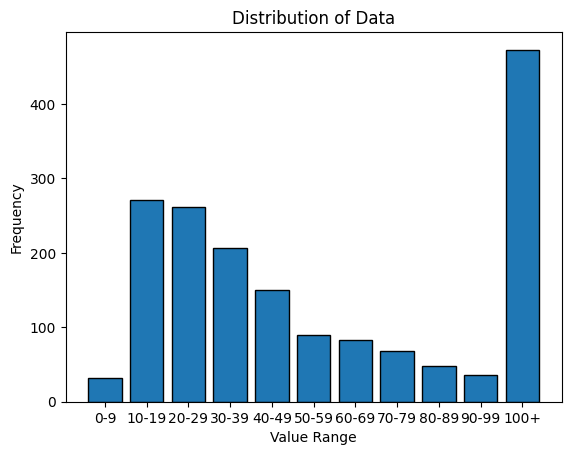

In [26]:
# 10 단위로 나누고, 100 이상 값을 하나로 묶기
bins = list(range(0, 101, 10)) + [float('inf')]
hist, bin_edges = np.histogram(ppl_list, bins=bins)

# 막대 그래프 그리기
bin_labels = [f'{i}-{i+9}' for i in range(0, 100, 10)] + ['100+']
plt.bar(bin_labels, hist, edgecolor='black')

# 그래프 제목과 축 레이블 설정
plt.title('Distribution of Data')
plt.xlabel('Value Range')
plt.ylabel('Frequency')


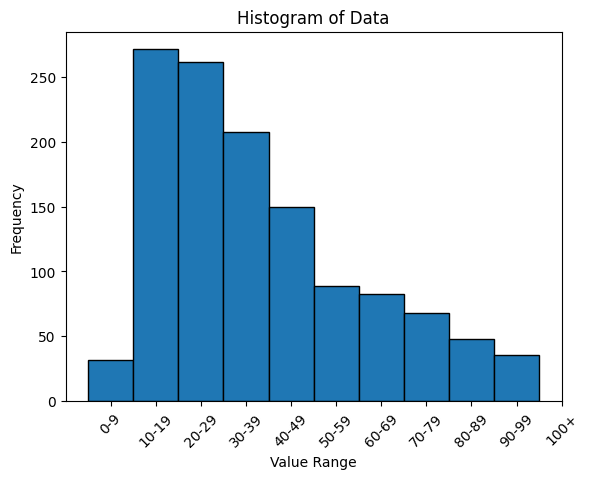

In [25]:
import matplotlib.pyplot as plt

bins = list(range(0, 101, 10)) + [float('inf')]

# 플롯 그리기
plt.hist(sorted(ppl_list), bins=bins, edgecolor='black', align='left')

# x축 레이블 설정
bin_labels = [f'{i}-{i+9}' for i in range(0, 100, 10)] + ['100+']
plt.xticks(bins[:-1], bin_labels, rotation=45)

# 플롯 제목과 축 레이블 설정
plt.title('Histogram of Data')
plt.xlabel('Value Range')
plt.ylabel('Frequency')

# 플롯 표시
plt.show()

In [9]:
data_array = np.array(ppl_list)

# NaN 값을 제외하고 평균 계산
mean_value = np.nanmean(data_array)
mean_value

458.59769982704154

In [10]:
import numpy as np

ber = [i['precision'][0] for i in bert]

rouge1 = np.mean([i['rouge1'] for i in rough])

rouge2 = np.mean([i['rouge2'] for i in rough])

rougeL = np.mean([i['rougeL'] for i in rough])

rougeLsum = np.mean([i['rougeLsum'] for i in rough])

mean_bleu_1 = np.mean(bleu_1_list)

mean_bleu_2 = np.mean(bleu_2_list)

print(f'PPL : {mean_value}, \nBertScore : {np.mean(ber)} \nrouge1 : {rouge1} \nrouge2 : {rouge2} \nrougeL : {rougeL} \nrougeLsum : {rougeLsum}, \nbleu_1 : {mean_bleu_1} \nbleu_2 : {mean_bleu_2} ')

PPL : 458.59769982704154, 
BertScore : 0.8608927405929346 
rouge1 : 0.1055118869909077 
rouge2 : 0.02198041612414733 
rougeL : 0.09848514792146265 
rougeLsum : 0.09848514792146265, 
bleu_1 : 0.03795522364934471 
bleu_2 : 0.017187785138514416 


In [13]:
distinct_ngrams(infer, 1)


0.19517634426364913

In [12]:
from collections import Counter
distinct_ngrams(infer, 1)
distinct_ngrams(infer, 2)

0.5661651234567902

In [22]:
np.mean(ber)

0.8492068219184875

In [26]:
rouge1 = np.mean([i['rouge1'] for i in rough])

rouge2 = np.mean([i['rouge2'] for i in rough])

rougeL = np.mean([i['rougeL'] for i in rough])

rougeLsum = np.mean([i['rougeLsum'] for i in rough])

In [29]:
mean_bleu = np.mean([i['bleu'] for i in bleu])

In [33]:
print(f'PPL : {calculate_mean(ppl_list)}, \nBertScore : {np.mean(ber)} \nrouge1 : {rouge1} \nrouge2 : {rouge2} \nrougeL : {rougeL} \nrougeLsum : {rougeLsum}, \nbleu : {mean_bleu}')

PPL : 6.603209018707275, 
BertScore : 0.8492068219184875 
rouge1 : 0.0864367417136198 
rouge2 : 0.016000117526532315 
rougeL : 0.07990215447014093 
rougeLsum : 0.07990215447014093, 
bleu : 0.007389715194612174
